# Imports

In [35]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functionsML as f
from itertools import combinations
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler

# data partition
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import importlib
importlib.reload(f)


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


**Import data sets**

In [ ]:
train_db = pd.read_csv("C:/Users/ricar/Desktop/cars4you/train.csv")
test_db = pd.read_csv("C:/Users/ricar/Desktop/cars4you/test.csv")

### Data exploration

## Distributions & Value Counts

## Fixing issues

In [165]:

# Drop irrelevant column
train_db = train_db.drop(columns="hasDamage")

train_db_numerical = train_db.select_dtypes(exclude=["object"]).columns
# Lowercase text columns
text_cols = train_db.select_dtypes(include=["object"]).columns
train_db[text_cols] = train_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)


# Loop and fix all categorical columns
for col in train_db.select_dtypes(include="object").columns:
    train_db = f.fix_typos(col, train_db)


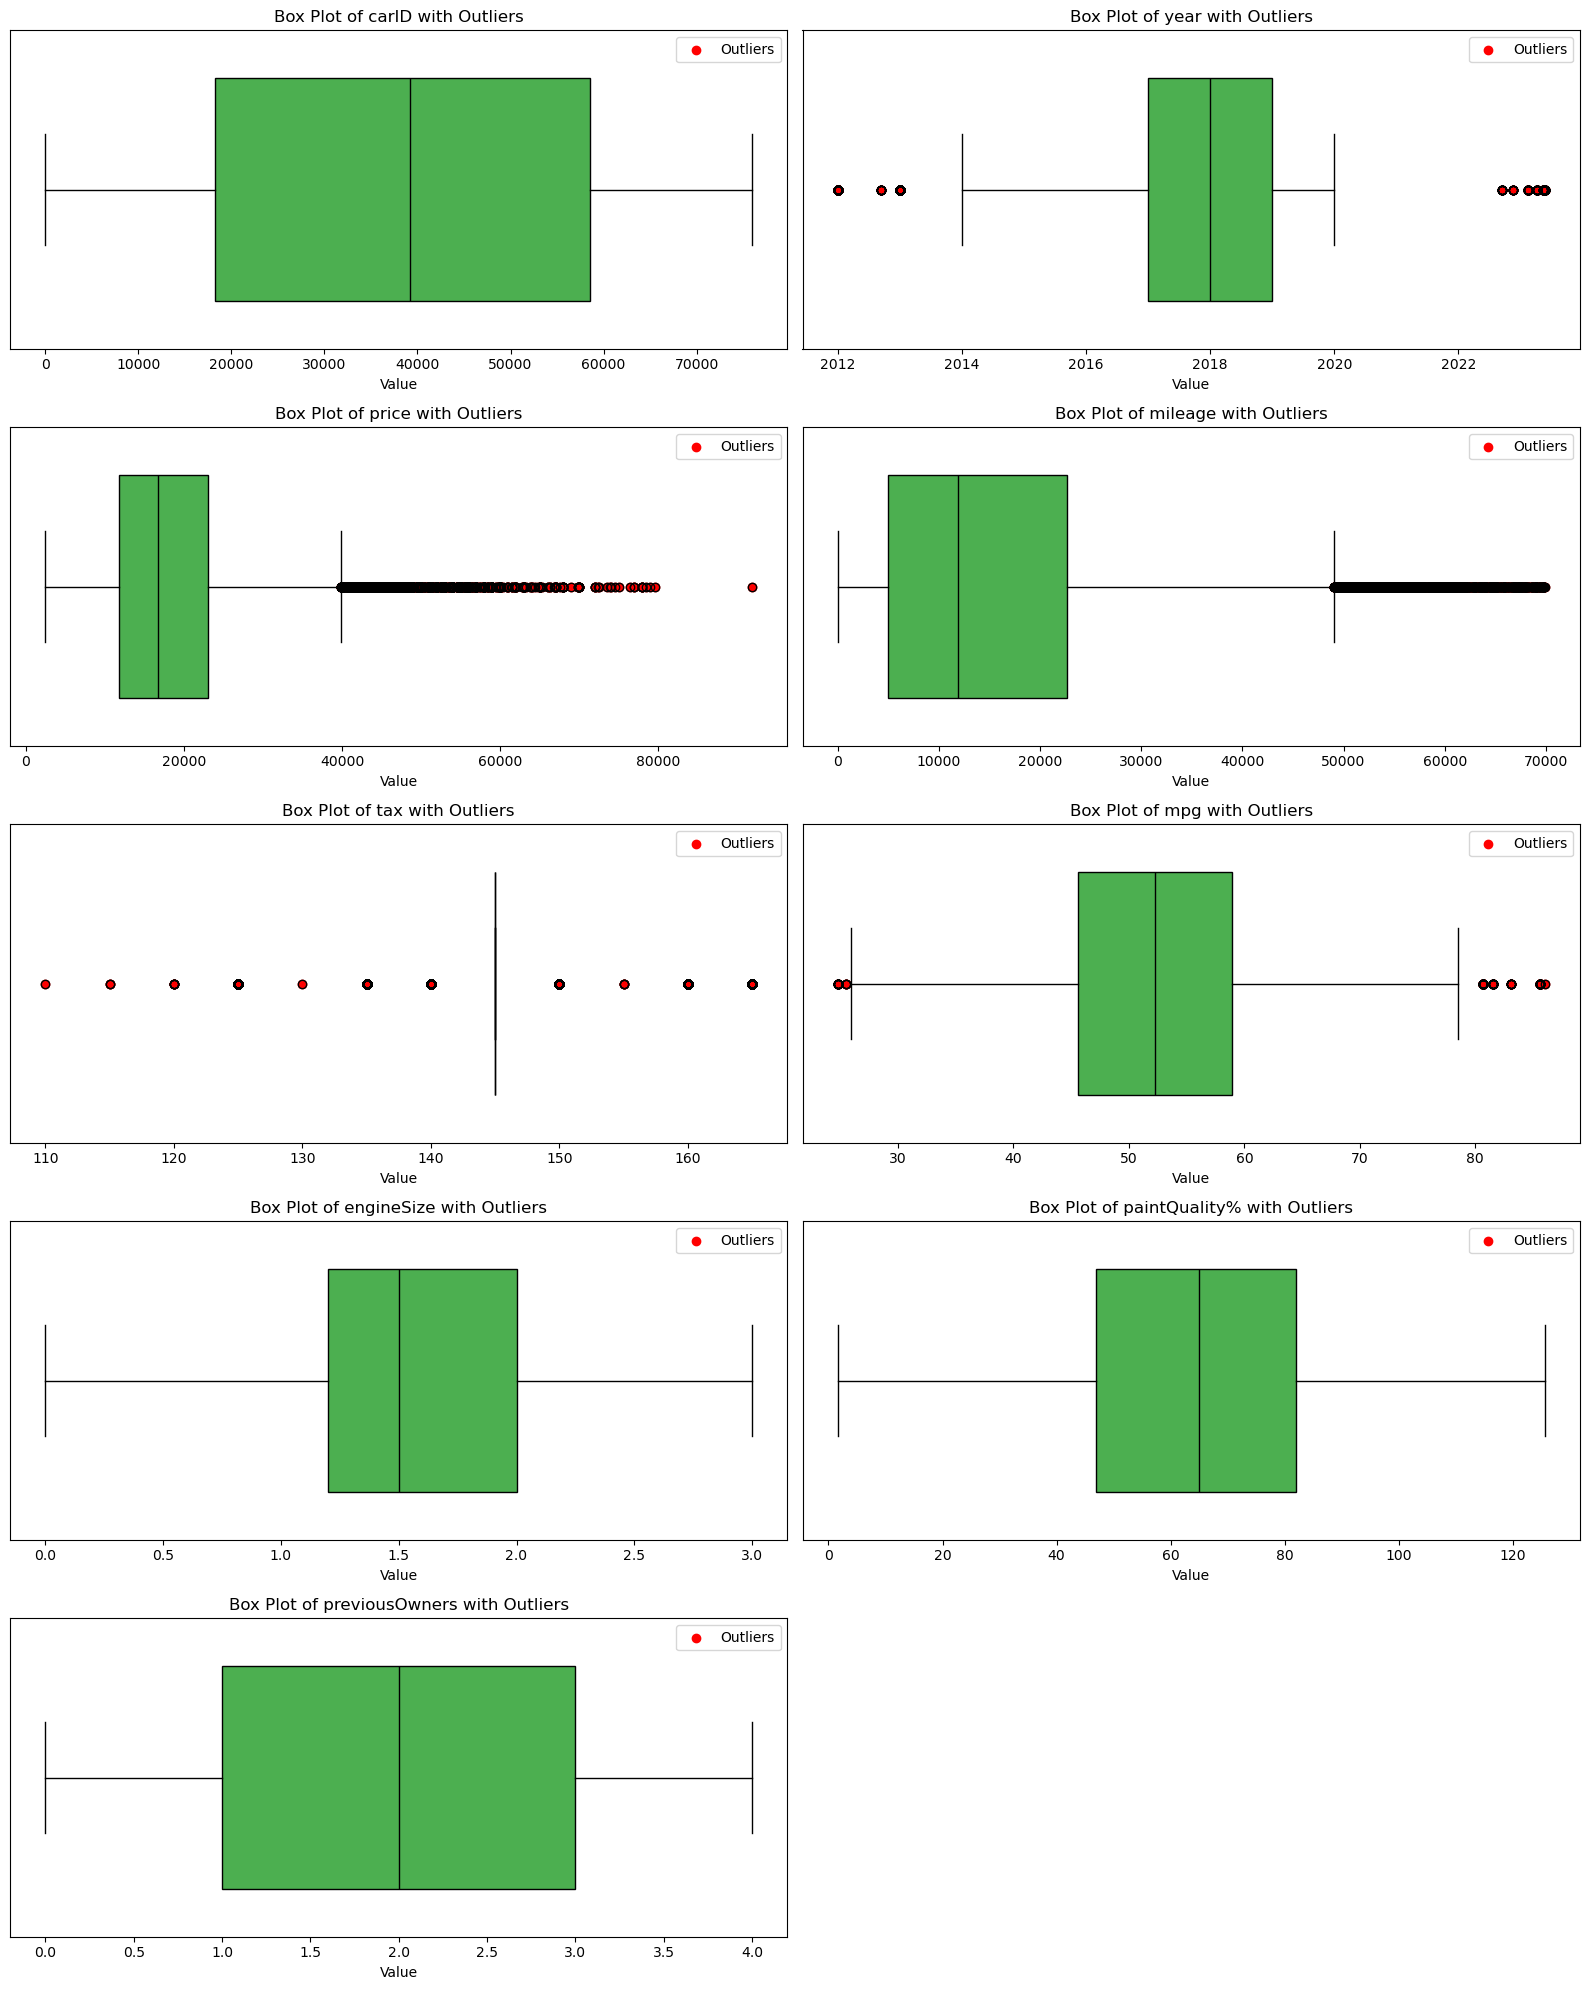

In [148]:
f.plot_multiple_boxes_with_outliers(train_db.dropna(), train_db_numerical)

In [151]:
numeric_cols = ["mileage", "tax", "mpg", "engineSize", "paintQuality%", "year", "previousOwners"]

# Copy of train dataset
train_db_filtered = train_db.copy()

for col in numeric_cols:
    Q1 = train_db_filtered[col].quantile(0.25)
    Q3 = train_db_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN
    train_db_filtered.loc[~train_db_filtered[col].between(lower_bound, upper_bound), col] = np.nan

train_db = train_db_filtered

In [ ]:
"""# Check each column before applying log1p
columns_to_transform = ['mileage', 'mpg', 'tax']

for col in columns_to_transform:
    print(f"\n--- Checking {col} ---")
    print(f"Min value: {train_db[col].min()}")
    print(f"Max value: {train_db[col].max()}")
    print(f"Number of negative values: {(train_db[col] < 0).sum()}")
    print(f"Number of NaN values: {train_db[col].isna().sum()}")
    
    # Check for values that would cause issues with log1p
    problematic = train_db[col] < -1  # log1p can't handle values <= -1
    if problematic.any():
        print(f"PROBLEM FOUND: {problematic.sum()} values <= -1")
        print("Problematic values:", train_db.loc[problematic, col].head().values)"""


--- Checking mileage ---
Min value: 1.0
Max value: 323000.0
Number of negative values: 0
Number of NaN values: 1832

--- Checking mpg ---
Min value: 1.1
Max value: 148.7
Number of negative values: 0
Number of NaN values: 8183

--- Checking tax ---
Min value: 0.0
Max value: 330.0
Number of negative values: 0
Number of NaN values: 8401


In [119]:
(train_db["engineSize"]).value_counts()

engineSize
2.000000    20105
1.000000    13615
1.500000     9156
1.400000     7432
1.600000     6381
1.200000     4750
3.000000     3806
2.100000     3624
1.800000     1192
1.300000      920
1.700000      618
1.100000      385
2.500000      312
2.200000      295
4.000000      295
2.300000      181
2.900000      116
2.631200       80
3.723712       63
2.985793       52
2.064119       51
4.400000       46
2.400000       43
5.000000       38
3.739235       38
5.500000       31
3.822758       27
2.800000       26
2.619641       25
1.900000       23
4.200000       20
2.781776       19
3.200000       19
4.700000       18
2.663113       17
5.200000       17
3.500000       12
2.700000        7
5.400000        2
2.600000        1
3.600000        1
4.300000        1
4.500000        1
4.100000        1
6.000000        1
Name: count, dtype: int64

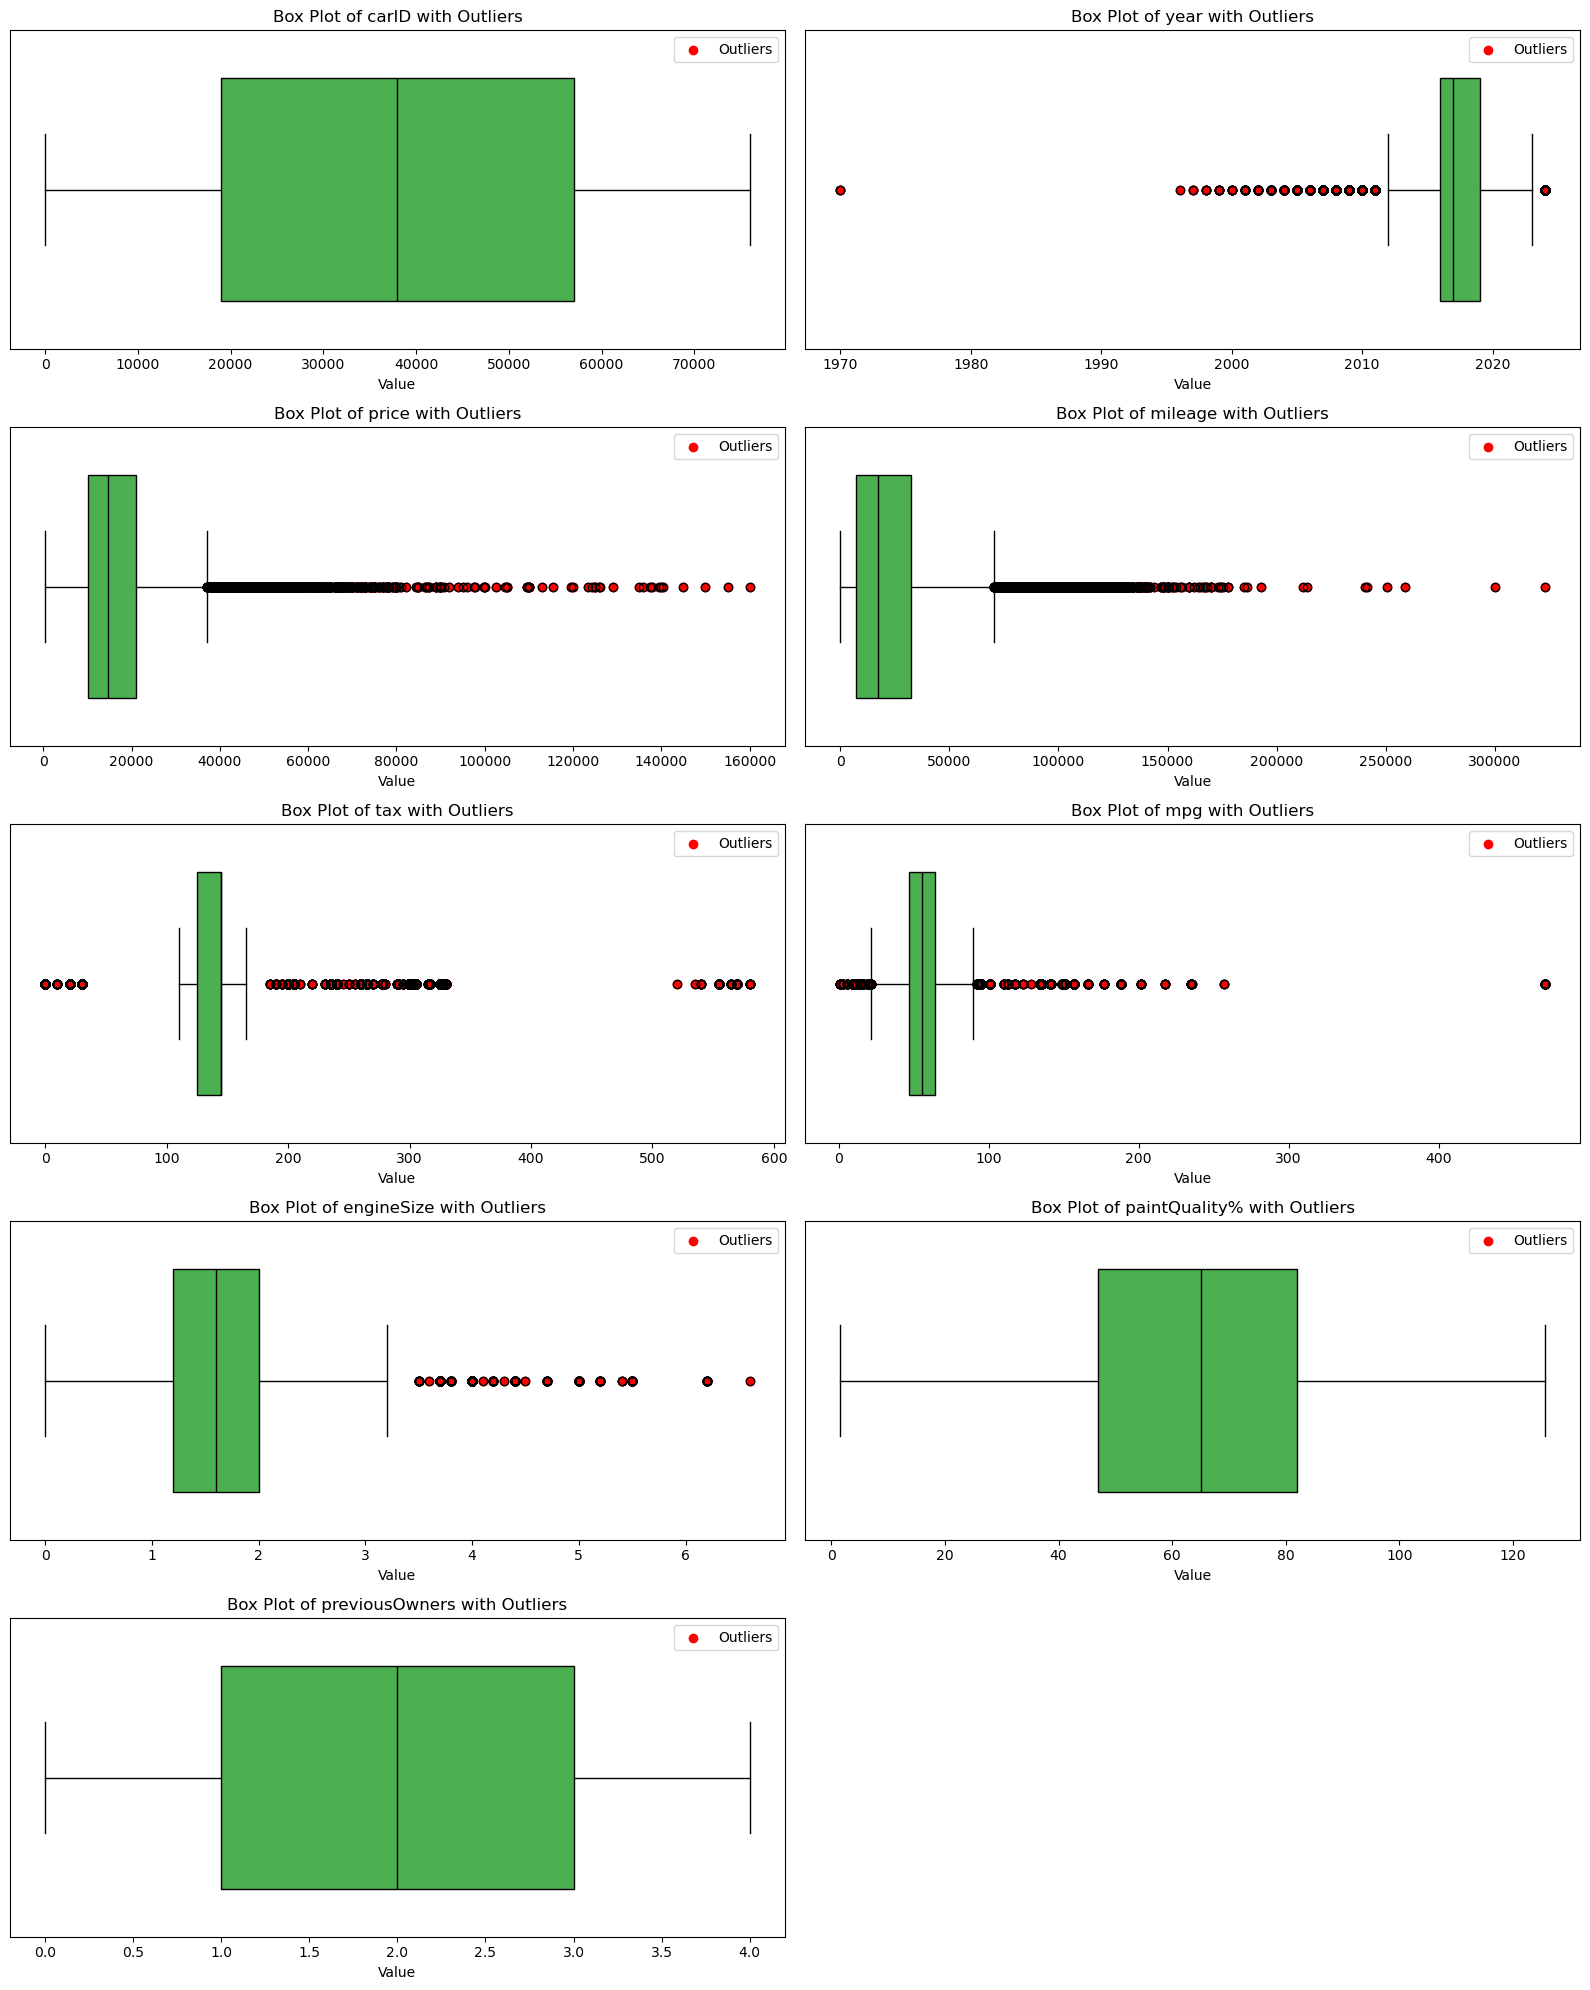

In [137]:
f.plot_multiple_boxes_with_outliers(train_db.dropna(), train_db_numerical)

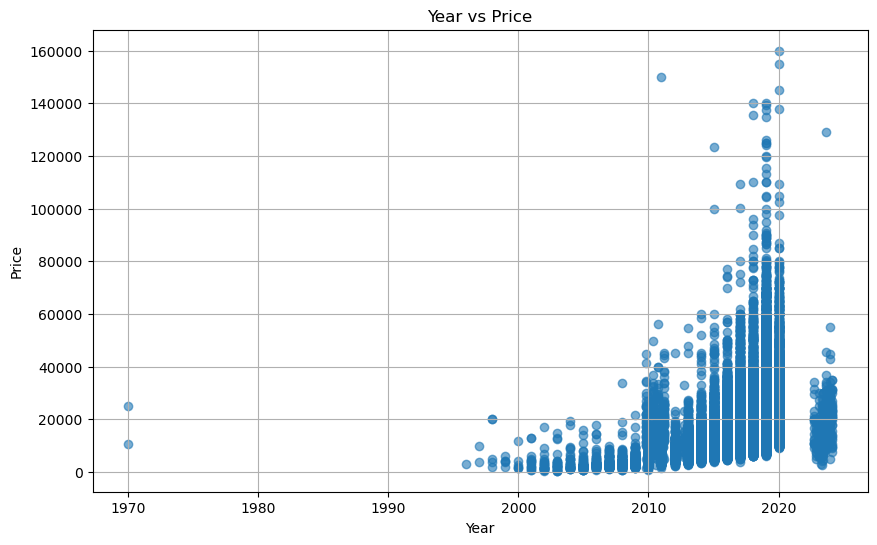

In [100]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train_db['year'], train_db['price'], alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Year vs Price')
plt.grid(True)
plt.show()


In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train_db['mileage'], train_db['price'], alpha=0.6)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Mileage vs Price')
plt.grid(True)
plt.show()


In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train_db['tax'], train_db['price'], alpha=0.6)
plt.xlabel('Tax')
plt.ylabel('Price')
plt.title('Tax vs Price')
plt.grid(True)
plt.show()



In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train_db['mpg'], train_db['price'], alpha=0.6)
plt.xlabel('mpg')
plt.ylabel('Price')
plt.title('mpg vs Price')
plt.grid(True)
plt.show()


In [82]:
train_db['price'] = np.log1p(train_db['price'])
train_db['mileage'] = np.log1p(train_db['mileage'])
train_db['mpg'] = np.log1p(train_db['mpg'])

lower, upper = train_db['tax'].quantile([0.01, 0.99])
train_db['tax'] = train_db['tax'].clip(lower, upper)
train_db['tax'] = np.log1p(train_db['tax'])

lower_es, upper_es = train_db['engineSize'].quantile([0.01, 0.99])
train_db['engineSize'] = train_db['engineSize'].clip(lower_es, upper_es)

# Save these values from your TRAIN data preprocessing
train_thresholds = {
    'tax_lower': lower,           # The 'lower' from train_db['tax'].quantile([0.01, 0.99])
    'tax_upper': upper,           # The 'upper' from train_db['tax'].quantile([0.01, 0.99])
    'engineSize_lower': lower_es, # The 'lower' from train_db['engineSize'].quantile([0.01, 0.99])  
    'engineSize_upper': upper_es  # The 'upper' from train_db['engineSize'].quantile([0.01, 0.99])
}


In [ ]:
f.plot_multiple_boxes_with_outliers(train_db.dropna(), train_db_numerical)

In [9]:
train_db["paintQuality%"].value_counts()

paintQuality%
34.000000     1147
94.000000     1128
54.000000     1114
32.000000     1107
88.000000     1099
              ... 
125.453599      23
2.725153        21
1.638913        19
125.188729      17
3.254760        15
Name: count, Length: 88, dtype: int64

In [ ]:
"""tax = train_db[train_db['tax'] > 400].shape[0]
mpg = train_db[train_db['mpg'] > 150].shape[0]
engineSize = train_db[train_db['engineSize'] > 3].shape[0]
mileage = train_db[train_db['mileage'] > 150000].shape[0]
price = train_db[train_db['price'] > 140000].shape[0]
year = train_db[train_db['year'] < 1990].shape[0]

print(f"""Outliers:
Tax: {tax},
MPG: {mpg},
Engine Size: {engineSize},
Mileage: {mileage},
Price: {price},
Year: {year}""")"""

Outliers:
Tax: 119,
MPG: 221,
Engine Size: 651,
Mileage: 37,
Price: 5,
Year: 2


In [ ]:
"""outlier_conditions = (
    (train_db['tax'] < 0) |
    (train_db['mpg'] > 150) |
    (train_db['engineSize'] > 3) |
    (train_db['mileage'] > 150000) |
    (train_db['price'] > 140000) |
    (train_db['year'] < 1990)
)"""

In [ ]:
"""train_db = train_db[~outlier_conditions]"""

In [166]:
# Rounding future Int values
train_db.loc[:, "year"] = train_db["year"].round()

# Removes every negative and irrational number from previousOwners
train_db.loc[(train_db['previousOwners'] < 0) | (train_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Rounds every irrational number into having one precision digit
for col in train_db.select_dtypes(include="float64").columns:
    # Round each column to 1 digit after the decimal
    train_db[col] = train_db[col].round(1)

# Remove paintQuality% above 100
test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan

# Remove every negative value out of the numeric columns
for col in train_db.select_dtypes(include="float64").columns:
    train_db = f.negative_to_nan_columns(col,train_db)

In [98]:
# Select all nominal columns
nominal_cols = train_db.select_dtypes(include='object').columns

# Compute Cramér's V between all pairs
for i, col1 in enumerate(nominal_cols):
    for col2 in nominal_cols[i+1:]:
        v = f.cramers_v(train_db[col1], train_db[col2])
        print(f"Cramér's V between {col1} and {col2}: {v:.3f}")


Cramér's V between Brand and model: 0.996
Cramér's V between Brand and transmission: 0.298
Cramér's V between Brand and fuelType: 0.287
Cramér's V between model and transmission: 0.362
Cramér's V between model and fuelType: 0.467
Cramér's V between transmission and fuelType: 0.202


In [6]:


num_cols = train_db.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns
cat_cols = train_db.select_dtypes(include=['object', 'category']).columns

# Try single and multi-column combinations up to this size
max_combo_size = 4 

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_db[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_db[target], joint_var)
            u_scores[joint_name] = u

    # pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:

For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979
  U(Brand | model) = 0.977
  U(Brand | transmission + fuelType) = 0.133
  U(Brand | transmission) = 0.093
  U(Brand | fuelType) = 0.053

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.562
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.520
  U(model | Brand) = 0.494
  U(model | transmission + fuelType) = 0.132
  U(model | transmission) = 0.071
  U(model | fuelType) = 0.070

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.327
  U(transmission | model + fuelType) = 0.317
  U(transmission | Brand + model) = 0.292
  U(transmission | model) = 0.282
  U(transmission | Brand + fuelType) = 0.230
  U(transmission | Brand) = 0.189


In [150]:

from itertools import combinations
def correlation_ratio(categories, values):
    df = pd.DataFrame({'cat': categories, 'val': values}).dropna()
    if df.empty:
        return 0.0
    group_stats = df.groupby('cat')['val'].agg(['mean', 'size'])
    overall_mean = df['val'].mean()
    num = (group_stats['size'] * (group_stats['mean'] - overall_mean) ** 2).sum()
    den = ((df['val'] - overall_mean) ** 2).sum()
    return np.sqrt(num / den) if den > 0 else 0.0

# Separate numeric and categorical columns
num_cols = train_db.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns
cat_cols = train_db.select_dtypes(exclude='number').columns

for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_db[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_pair in combinations(cat_cols, num_paired):
            combined = train_db[list(cat_pair)].astype(str).agg('_'.join, axis=1)
            scores[cat_pair] = correlation_ratio(combined, train_db[target]) ** 2


    # --- Mixed numeric + categorical pairs  ---
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_db[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=15, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = correlation_ratio(combined, df[target]) ** 2

    # --- Top 3 helpers ---
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")


KeyboardInterrupt: 

### -----POR DAR CLEAN UP-----

In [167]:
# Safely convert previousOwners and year to nullable integers
train_db["previousOwners"] = pd.to_numeric(train_db["previousOwners"], errors='coerce').round().astype("Int64")
train_db["year"] = pd.to_numeric(train_db["year"], errors='coerce').round().astype("Int64")

# Handle Brand for i3
idx_to_drop = train_db[(train_db['model'] == 'i3') & (train_db['Brand'].isna())].index
train_db = train_db.drop(idx_to_drop)

# Fill categorical columns
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission"])
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission"])
train_db = f.fill_NaN_with_categorical(train_db, "mpg", ["model","fuelType"])
train_db["transmission"] = train_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_db["fuelType"] = train_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
train_db = f.fill_NaN_with_mixed(train_db, "year", "model", "mileage")
train_db = f.fill_NaN_with_mixed(train_db, "mileage", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "tax", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "engineSize", "model", "tax")

# Fill numeric columns with median
train_db["paintQuality%"] = train_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
train_db["previousOwners"] = train_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Drop any remaining NaNs
train_db = train_db.dropna()


c:\Users\ricar\Documents\GitHub\ProjetoML\functionsML.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(helper_cols, dropna=False, group_keys=False ).apply(fill_group_cat, target_col)
c:\Users\ricar\Documents\GitHub\ProjetoML\functionsML.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(helper_cols, dropna=False, group_keys=False ).apply(fill_group_cat, target_col)


In [53]:
train_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57813 entries, 1 to 75972
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           57813 non-null  int64  
 1   Brand           57813 non-null  object 
 2   model           57813 non-null  object 
 3   year            57813 non-null  Int64  
 4   price           57813 non-null  float64
 5   transmission    57813 non-null  object 
 6   mileage         57813 non-null  float64
 7   fuelType        57813 non-null  object 
 8   tax             57813 non-null  float64
 9   mpg             57813 non-null  float64
 10  engineSize      57813 non-null  float64
 11  paintQuality%   57813 non-null  float64
 12  previousOwners  57813 non-null  Int64  
dtypes: Int64(2), float64(6), int64(1), object(4)
memory usage: 8.3+ MB


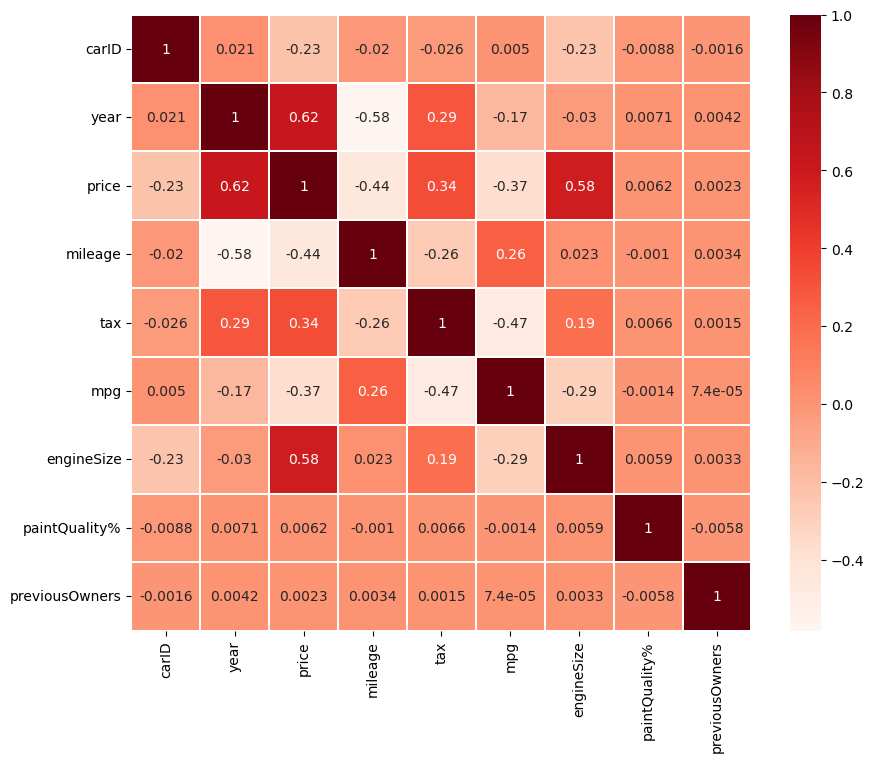

In [54]:
# Remove rows with missing values
temp = train_db.dropna()

# Select numerical columns for correlation analysis
corr_data = temp.select_dtypes(include=["number"])

# Compute the Pearson correlation matrix
correlation_matrix = corr_data.corr(method="pearson")

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap = plt.cm.Reds, linewidths=0.1)
plt.show()

In [168]:
one_hot = pd.get_dummies(train_db["Brand"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot], axis=1)

train_db['transmission'] = train_db['transmission'].replace('other', 'unknown')

one_hot2 = pd.get_dummies(train_db["transmission"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot2], axis=1)

train_db["fuelType"] = train_db["fuelType"].replace('other', 'electric')

one_hot3 = pd.get_dummies(train_db["fuelType"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot3], axis=1)


In [ ]:
"""for col in ["manual", "semi-auto", "unknown","hybrid"]:
    print(train_db[col].value_counts())"""

manual
1    43144
0    32819
Name: count, dtype: int64
semi-auto
0    59092
1    16871
Name: count, dtype: int64
unknown
0    75222
1      741
Name: count, dtype: int64
hybrid
0    73738
1     2225
Name: count, dtype: int64


In [169]:
train_db = f.kfold_target_encode(train_db, cat_col='model', target_col='price', n_splits=5)

print(train_db[['model', 'price', 'model_encoded']].head(100))

        model  price  model_encoded
0        golf  22290   16734.152523
1       yaris  13790   10518.178082
2          q2  24990   23222.126882
3      fiesta  12500   10224.591166
4    2 series  22995   19825.349782
..        ...    ...            ...
95        i20   9995    8790.976923
96     fiesta   8930   10255.578844
97      focus   9699   14011.088899
98  gls class  67600   45832.204545
99      b-max   9498    8327.015000

[100 rows x 3 columns]


c:\Users\ricar\Documents\GitHub\ProjetoML\functionsML.py:484: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f'{cat_col}_encoded'].fillna(overall_mean, inplace=True)


In [170]:
X = train_db.drop(columns=["price","carID"])
y = train_db["price"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  shuffle = True)

In [171]:
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)

# repeat for val

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)

In [172]:
scaler = MinMaxScaler()

#fit to training data
scaler.fit(X_train_num)

#transform the data
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)


#show results
X_train_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,bmw,ford,hyundai,...,skoda,toyota,vw,manual,semi-auto,unknown,electric,hybrid,petrol,model_encoded
55979,0.851852,0.105855,0.034483,0.140941,0.303030,0.680645,1.00,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.113756
59635,0.851852,0.040864,0.051724,0.131360,0.303030,0.575806,0.50,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.108294
74650,0.870370,0.056115,0.000000,0.155844,0.272727,0.285484,0.00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.173702
1593,0.888889,0.035084,0.250000,0.134341,0.151515,0.333871,1.00,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.089827
71303,0.851852,0.109025,0.034483,0.144347,0.242424,0.374194,1.00,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.081999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21246,0.851852,0.134075,0.215517,0.120290,0.303030,0.382258,0.50,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.191283
45899,0.870370,0.015972,0.344828,0.087503,0.212121,0.366129,0.25,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.078500
42618,0.907407,0.017963,0.250000,0.090270,0.212121,0.422581,0.50,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.062165
43573,0.907407,0.025152,0.250000,0.111135,0.196970,0.777419,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.166417


In [173]:
for var in X_train_cat:
    f.TestCorrelationRatio(X_train_cat[var],y_train, var)

Brand is IMPORTANT for prediction (η = 0.538)
model is IMPORTANT for prediction (η = 0.760)
transmission is IMPORTANT for prediction (η = 0.544)
fuelType is IMPORTANT for prediction (η = 0.210)


In [158]:
nof_list = np.arange(1, len(X_train_num_scaled.columns) + 1)
high_score = 0
nof = 0  # Variable to store the optimum features
train_score_list = []
val_score_list = []

for n_features in nof_list:
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    # RFE to select top n_features
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(X_train_num_scaled, y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    
    # Fit model
    model.fit(X_train_rfe, y_train)
    
    # Training score
    train_score = model.score(X_train_rfe, y_train)
    train_score_list.append(train_score)
    
    # Validation score
    val_score = model.score(X_val_rfe, y_val)
    val_score_list.append(val_score)
    
    # Check for best score
    if val_score >= high_score:
        high_score = val_score
        nof = n_features

print(f"Optimum number of features: {nof}")
print(f"Score with {nof} features: {high_score:.3f}")

KeyboardInterrupt: 

In [159]:
model = RandomForestRegressor()

rfe = RFE(estimator = model, n_features_to_select = 22)

train_db_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)

rfe.support_

c:\ProgramData\anaconda3\envs\Fall25267\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=22 > n_features=21. There will be no feature selection and all features will be kept.
  warnings.warn(


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [17]:
X_train_num_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'bmw', 'ford', 'hyundai', 'mercedes', 'opel', 'skoda',
       'toyota', 'vw', 'manual', 'semi-auto', 'unknown', 'electric', 'hybrid',
       'petrol', 'model_encoded'],
      dtype='object')

In [18]:
rfe.ranking_

array([1, 1, 2, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [72]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

year              True
mileage           True
tax               True
mpg               True
engineSize        True
paintQuality%     True
previousOwners    True
bmw               True
ford              True
hyundai           True
mercedes          True
opel              True
skoda             True
toyota            True
vw                True
manual            True
semi-auto         True
unknown           True
electric          True
hybrid            True
petrol            True
model_encoded     True
dtype: bool

In [160]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_num_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 20 variables and eliminated the other 1 variables


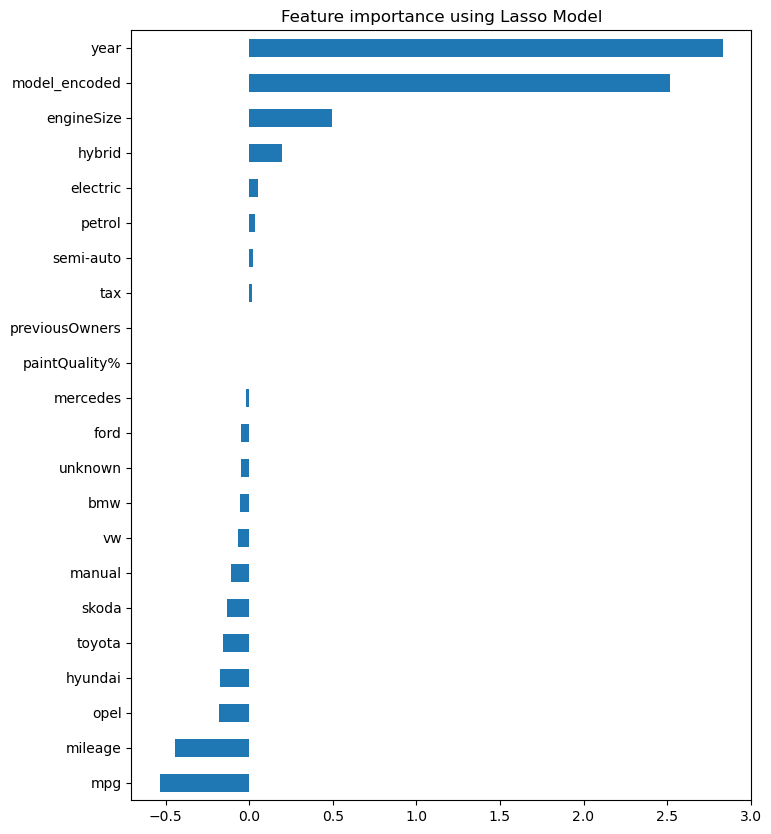

In [74]:
plot_importance(coef,'Lasso')

<hr>

### Numerical Data

| Predictor | Spearman | RFE LR| Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |---|
| year | Keep? | Keep | Keep | Include in the model |
| engineSize | Keep | Keep |Keep| Include in the model |
| tax | Keep?| Keep | Discard | Try with and without |
| previousOwners | Keep? | Discard | Discard | Discard |
| paintQuality% | Keep? | Discard | Discard | Discard |
| mpg | Keep? | Keep | Keep? | Try with and without |
| mileage | Keep | Keep | Keep | Keep |

<hr>


### Categorical Data

| Predictor | Correlation Ratio | 
| --- | --- | 
| Brand | Keep |  
|  model | Keep | 
| transmission | Keep |
| fuelType| Keep? |


<hr>



In [174]:
X_train_num_scaled = X_train_num_scaled.drop(columns=['previousOwners', "paintQuality%"])

X_val_num_scaled = X_val_num_scaled.drop(columns=['previousOwners', "paintQuality%"])

In [175]:
model = RandomForestRegressor(
    n_estimators=100,   # number of trees
    random_state=42,    # for reproducibility
    n_jobs=-1           # use all cores
)
model.fit(X_train_num_scaled, y_train)

# 4. Predict
y_pred = model.predict(X_val_num_scaled)

# 5. Evaluate
print(f"R²: {r2_score(y_val, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.2f}")

R²: 0.943
MAE: 1339.80
RMSE: 2337.94


In [178]:
# Drop irrelevant column
test_db = test_db.drop(columns="hasDamage")

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Loop and fix all categorical columns (if your fix_typos function works for test set)
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)

# Rounding future Int values
test_db.loc[:, "year"] = test_db["year"].round()

# Remove negative/irrational previousOwners
test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats to 1 digit
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Remove paintQuality% above 100
test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan

# Remove negative values from numeric columns
for col in test_db.select_dtypes(include="float64").columns:
    test_db = f.negative_to_nan_columns(col, test_db)

# Safely convert previousOwners and year to nullable integers
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# Fill categorical columns using the same functions as training
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

# Fill numeric columns with median
test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')

for col in numeric_cols:
    # Convert to float to safely handle NaNs and group means
    test_db[col] = test_db[col].astype(float)
    
    # Compute model mean
    category_means = test_db.groupby("model")[col].transform('median')
    
    # Fill NaNs with category mean
    test_db[col] = test_db[col].fillna(category_means)
    
    # Fill any remaining NaNs with global mean
    global_mean = test_db[col].median()
    test_db[col] = test_db[col].fillna(global_mean)
    
    # Optional: convert back to integer if column was originally integer
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")



        
# One-hot encode categorical columns
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

# Merge rare transmission values
test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

# Merge rare fuelType values
test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)


# Create mapping dictionary from train_df
mapping = train_db.set_index("model")["model_encoded"].to_dict()

# Compute global mean in case test has unseen models
global_mean = train_db["model_encoded"].median()

# Map test_df model to encoded value; unseen models get global_mean
test_db["model_encoded"] = test_db["model"].map(mapping).fillna(global_mean)

# Prepare features (exclude price and ID if present)
X_test = test_db.drop(columns=["carID"], errors='ignore')  # ignore if price not in test
X_test_num = X_test.select_dtypes(include=np.number).set_index(X_test.index)

# Scale using the same scaler fitted on training data
X_test_num_scaled = scaler.transform(X_test_num)

X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns).set_index(X_test.index)

X_test_num_scaled = X_test_num_scaled.drop(columns=[ 'previousOwners', "paintQuality%"])

c:\Users\ricar\Documents\GitHub\ProjetoML\functionsML.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(helper_cols, dropna=False, group_keys=False ).apply(fill_group_cat, target_col)
c:\Users\ricar\Documents\GitHub\ProjetoML\functionsML.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(helper_cols, dropna=False, group_keys=False ).apply(fill_group_cat, target_col)


In [179]:
y_test_pred = model.predict(X_test_num_scaled)

# Add predictions to the test DataFrame
#test_db['price'] = np.expm1(y_test_pred)
test_db['price'] = (y_test_pred)

# Create a new DataFrame with only carID and predicted price
submission = test_db[['carID', 'price']].copy()

# Save to CSV
submission.to_csv("predicted_prices.csv", index=False)
